In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(34)
sns.set()

Напишем класс линейной регрессии с $L2$-регуляризацией. То есть минимизируется следующая функция:

$$
\frac{1}{n} \sum_{i=1}^n (w^T x_i + b - y_i)^2 + \lambda \cdot \|w\|_2^2
$$

In [2]:
def print_loss(X, Y, w, b, reg_coef, mode):
    MSE = np.square(X @ w + b - Y.reshape(-1, 1)).mean()
    R = reg_coef * float(w.T @ w) / X.shape[0]
    print(f"{mode} MSE: {round(MSE, 3)}")
    print(f"{mode} loss: {round(MSE + R, 3)}")
    print("-" * 42)
    return MSE

class RegularizedLinearRegression:
    def __init__(self, reg_coef):
        self.reg_coef = reg_coef
    
    def fit(self, X, Y, lr=1e-1, num_epochs=70, log_interval=250):
        n, d = X.shape
        
        w = np.zeros((d, 1))
        b = 0
        
        for epoch in range(num_epochs):
            if epoch % log_interval == 0:
                print_loss(X, Y, w, b, self.reg_coef, "Train")
            
            dMSEdw = 2 * X.T @ (X @ w + b - Y.reshape(-1, 1)) / n
            dMSEdb = float(np.mean(2 * (X @ w + b - Y.reshape(-1, 1))))

            dRdw = 2 * self.reg_coef * w

            w = w - lr * (dMSEdw + dRdw)
            b = b - lr * dMSEdb
        
        assert w.shape == (d, 1), w.shape
        assert type(b) == float, type(b)
        print_loss(X, Y, w, b, self.reg_coef, "Train")
        return w, b

Сгенерируем набор данных: синус с добавлением шума. Разделим на обучающую и тестовую выборки

In [3]:
N = 20
N_train = 15

deg_from = -130
deg_to = 130

X = np.linspace(deg_from, deg_to, N) * np.pi / 180
Y_true = np.sin(X)
Y = Y_true + np.random.randn(N) * 0.2

perm = np.random.permutation(N)
train_inds = np.sort(perm[:N_train])
test_inds = np.sort(perm[N_train:])

X_train, Y_train = X[train_inds], Y[train_inds]
X_test, Y_test = X[test_inds], Y[test_inds]

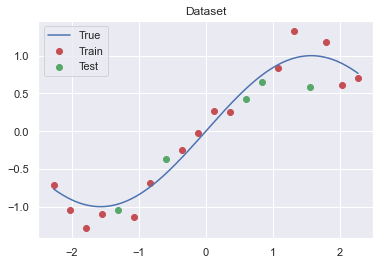

In [4]:
plt.plot(np.linspace(deg_from, deg_to, 10000) * np.pi / 180,
         np.sin(np.linspace(deg_from, deg_to, 10000) * np.pi / 180), c='b', label='True')
plt.scatter(X_train, Y_train, c='r', label='Train')
plt.scatter(X_test, Y_test, c='g', label='Test')
plt.title('Dataset')
plt.legend()
plt.show()

Сделаем модель сложной, добавив степени признака до 15. То есть будем аппроксимировать многочленом 15 степени.

In [5]:
degree = 15

X_train_deg = np.array([
    X_train**d for d in range(1, degree + 1)
]).transpose()

X_test_deg = np.array([
    X_test**d for d in range(1, degree + 1)
]).transpose()

**Нормализация**

In [6]:
means = X_train_deg.mean(axis=0).reshape(1, -1)
stds = X_train_deg.std(axis=0).reshape(1, -1)

X_train_deg = (X_train_deg - means) / stds
X_test_deg = (X_test_deg - means) / stds

**Обучение модели**

In [7]:
model = RegularizedLinearRegression(reg_coef=0.)
w, b = model.fit(X_train_deg, Y_train, lr=0.05, num_epochs=1000)

Train MSE: 0.744
Train loss: 0.744
------------------------------------------
Train MSE: 0.022
Train loss: 0.022
------------------------------------------
Train MSE: 0.014
Train loss: 0.014
------------------------------------------
Train MSE: 0.013
Train loss: 0.013
------------------------------------------
Train MSE: 0.012
Train loss: 0.012
------------------------------------------


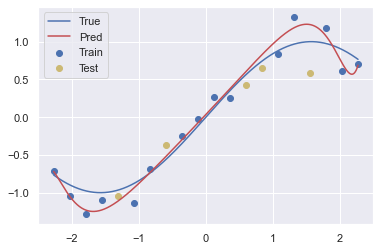

In [8]:
plt.plot(np.linspace(deg_from, deg_to, 10000) * np.pi / 180,
         np.sin(np.linspace(deg_from, deg_to, 10000) * np.pi / 180), c='b', label='True')

space = np.array([
    (np.pi / 180 * np.linspace(deg_from, deg_to, 10000))**d for d in range(1, degree + 1)
]).transpose()
space = (space - means) / stds

plt.plot(np.pi / 180 * np.linspace(deg_from, deg_to, 10000), space @ w + b, c='r', label='Pred')

plt.scatter(X_train, Y_train, c='b', label='Train')
plt.scatter(X_test, Y_test, c='y', label='Test')
plt.legend()
plt.show()

In [9]:
print_loss(X_train_deg, Y_train, w, b, 0, "Train")
print_loss(X_test_deg, Y_test, w, b, 0, "Test");

Train MSE: 0.012
Train loss: 0.012
------------------------------------------
Test MSE: 0.102
Test loss: 0.102
------------------------------------------


In [10]:
round(np.linalg.norm(w), 2)

1.6

#### Добавим регуляризацию

In [11]:
model = RegularizedLinearRegression(reg_coef=0.05)
w, b = model.fit(X_train_deg, Y_train, lr=0.05, num_epochs=1000)

Train MSE: 0.744
Train loss: 0.744
------------------------------------------
Train MSE: 0.042
Train loss: 0.045
------------------------------------------
Train MSE: 0.039
Train loss: 0.042
------------------------------------------
Train MSE: 0.038
Train loss: 0.042
------------------------------------------
Train MSE: 0.038
Train loss: 0.042
------------------------------------------


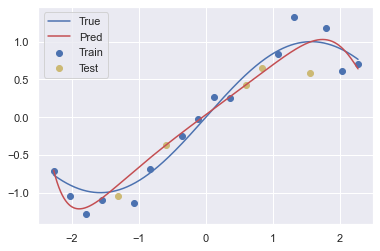

In [12]:
plt.plot(np.linspace(deg_from, deg_to, 10000) * np.pi / 180,
         np.sin(np.linspace(deg_from, deg_to, 10000) * np.pi / 180), c='b', label='True')

space = np.array([
    (np.pi / 180 * np.linspace(deg_from, deg_to, 10000))**d for d in range(1, degree + 1)
]).transpose()
space = (space - means) / stds

plt.plot(np.pi / 180 * np.linspace(deg_from, deg_to, 10000), space @ w + b, c='r', label='Pred')

plt.scatter(X_train, Y_train, c='b', label='Train')
plt.scatter(X_test, Y_test, c='y', label='Test')
plt.legend()
plt.show()

In [13]:
print_loss(X_train_deg, Y_train, w, b, 0.05, "Train")
print_loss(X_test_deg, Y_test, w, b, 0.05, "Test");

Train MSE: 0.038
Train loss: 0.042
------------------------------------------
Test MSE: 0.039
Test loss: 0.049
------------------------------------------


In [14]:
round(np.linalg.norm(w), 2)

1.02

**Изменение ошибок в зависимости от коэффициента регуляризации**

In [15]:
%%capture

norms = []
test_losses = []
train_losses = []

for coef in np.logspace(-3, 1, 20):
    model = RegularizedLinearRegression(reg_coef=coef)
    w, b = model.fit(X_train_deg, Y_train, lr=0.05, num_epochs=2000)
    test_losses.append(print_loss(X_test_deg, Y_test, w, b, coef, "Test"))
    train_losses.append(print_loss(X_train_deg, Y_train, w, b, coef, "Train"))
    norms.append(np.linalg.norm(w))

Чем меньше регуляризация, тем сложнее модель

In [16]:
train_losses = train_losses[::-1]
test_losses = test_losses[::-1]

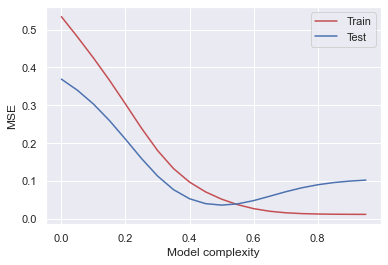

In [17]:
plt.plot(np.arange(20) / 20, train_losses, label="Train", c="r")
plt.plot(np.arange(20) / 20, test_losses, label="Test", c="b")
plt.ylabel("MSE")
plt.xlabel("Model complexity")
plt.legend()
plt.show()

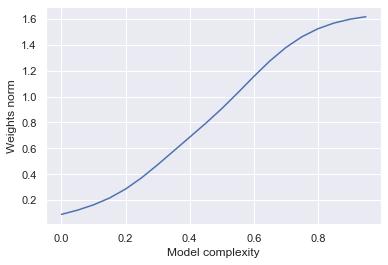

In [18]:
plt.plot(np.arange(20) / 20, norms[::-1])
plt.ylabel("Weights norm")
plt.xlabel("Model complexity")
plt.show()